<h1>SegmentEveryGrain -- Hawaii project</h1>

Details go here

<h3>To-do</h3>

- Break interactive elements into segmenteverygrain.interactions
- Create tests for interactive elements?
- Sort out grain_data, all_grain, new_grain_data, etc
- Performance improvements?

In [1]:
# Setup ---

# Tensorflow compatibility with legacy Keras models
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Other imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segment_anything
import segmenteverygrain
import segmenteverygrain.interactions as si
import tf_keras

# import tensorflow as tf
# from tensorflow.python.platform.build_info import build_info

# for k, v in build_info.items():
#     print(f'{k}:\t{v}')

# Plotting
%matplotlib widget
FIGSIZE = (12, 8)

2024-11-25 16:22:42.740285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732576962.831626    3923 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732576962.856276    3923 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 16:22:43.060833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I0000 00:00:1732576974.996209    3923 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6055 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


segmenting image tiles...


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


([], [])

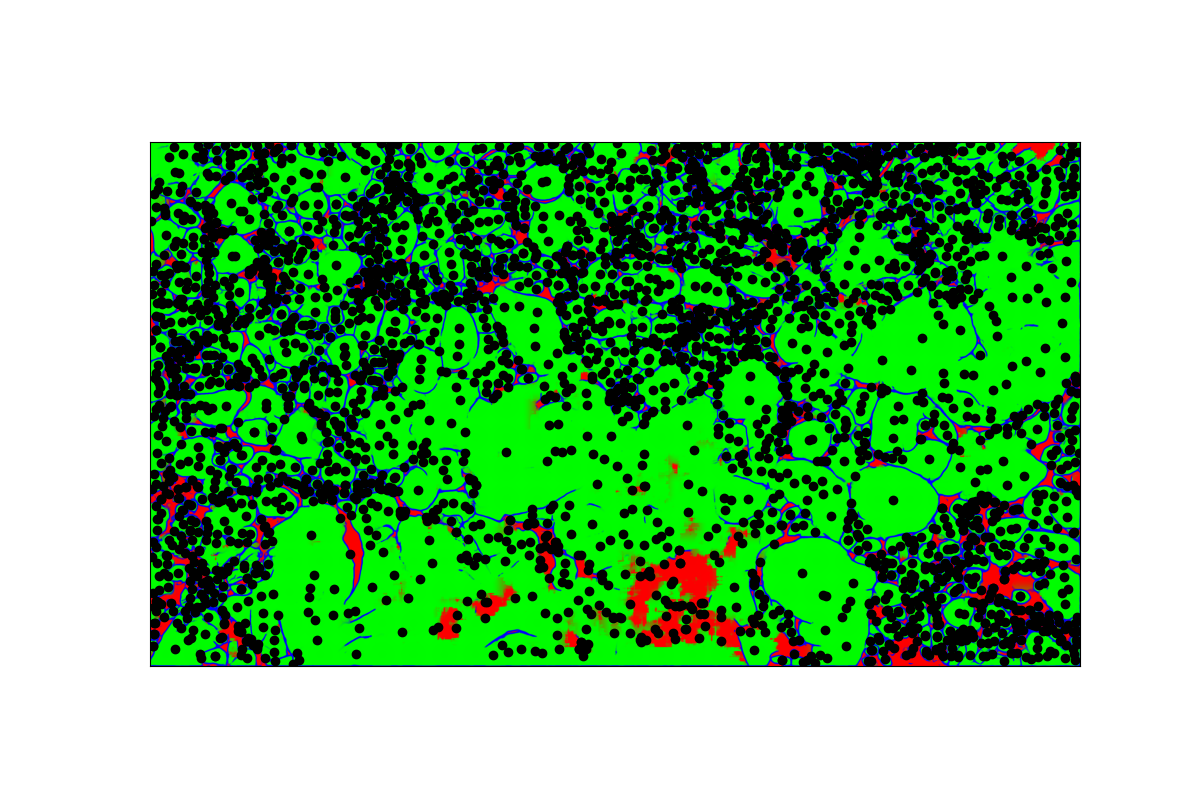

In [2]:
# Unet segmentation ---

# Load Unet model
model = segmenteverygrain.Unet()
model.compile(
    optimizer=tf_keras.optimizers.legacy.Adam(),
    loss=segmenteverygrain.weighted_crossentropy,
    metrics=["accuracy"])
model.load_weights('./segmenteverygrain/checkpoints/seg_model')
# model.load_weights('./segmenteverygrain/new_model/seg_model_060800')

# Load image for analysis
fname = './DJI_0605010.jpg'
image = np.array(tf_keras.preprocessing.image.load_img(fname))

# Generate Unet prompts
image_pred = segmenteverygrain.predict_image(image, model, I=256)
labels, coords = segmenteverygrain.label_grains(image, image_pred, dbs_max_dist=20.0)

# Display Unet prompts for verification
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_aspect('equal')
ax.imshow(image_pred)
plt.scatter(np.array(coords)[:,0], np.array(coords)[:,1], c='k')
plt.xticks([])
plt.yticks([])

In [ ]:
# SAM segmentation ---

# Close Unet figure
plt.close()

# Load and apply Segment Anything model
sam = segment_anything.sam_model_registry["default"](checkpoint="./sam_vit_h_4b8939.pth")
# TODO: Figure out TensorRT to accelerate this w/GPU
# sam.to(device='cuda')
# TODO: Separate into smaller chunks (plotting, mask, etc)
# TODO: Choose min_area by image size? Do unit conversion from pixels first?
all_grains, labels, mask_all, grain_data, fig, ax = segmenteverygrain.sam_segmentation(
    sam, image, image_pred, coords, labels, 
    min_area=400.0, plot_image=False, remove_edge_grains=False, remove_large_objects=False
)

# Set up predictor for interaction plot
# TODO: this already happens in sam_segmentation!
predictor = segment_anything.SamPredictor(sam)
predictor.set_image(image)

/home/emma/.pyenv/versions/venv4/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


creating masks using SAM...


 23%|██▎       | 815/3485 [04:29<09:49,  4.53it/s]  

In [ ]:
# Manual editing ---

# Create and display interactive grain plot
grains = [si.Grain(p.exterior.xy, row[1]) for p, row in zip(all_grains, grain_data.iterrows())]
grain_plot = si.GrainPlot(grains, image=image, predictor=predictor, figsize=FIGSIZE)
grain_plot.activate()

In [ ]:
# Process manual edits ---

# Disable further interactions
grain_plot.deactivate()

# Get grain data as pd.DataFrame
new_grain_data = grain_plot.get_data()
# print(new_grain_data.head())

# TODO: Convert from pixels to real units
n_of_units = 1000
units_per_pixel = n_of_units/1552.77 # length of scale bar in pixels
for col in ['major_axis_length', 'minor_axis_length', 'perimeter', 'area']:
    new_grain_data[col] *= units_per_pixel

# Save csv, show histogram
new_grain_data.to_csv(fname[:-4] + '.csv')
fig, ax = segmenteverygrain.plot_histogram_of_axis_lengths(new_grain_data['major_axis_length']/1000, new_grain_data['minor_axis_length']/1000)

# Save mask with original image for training
dirname = './images/'
outname = dirname + fname.split('/')[-1].split('.')[-2]
rasterized_image, mask = grain_plot.get_mask()
# TODO: Remove opencv dependency?
cv2.imwrite(outname + '_mask.png', mask)
cv2.imwrite(outname + '_verify.png', mask*127)
cv2.imwrite(outname + '_image.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

<h2>Results</h2>

At the end of this script, you should have the following where "fname" is the name input image (without file extension):

- Cell output in this notebook (can be saved manually):
    - A plot of Unet prompts generated for Segment Anything to analyze. If this looks messy, consider fine-tuning the model.
    - A colorized plot of detected grains, after manual edits.
    - A histogram of grain axis lengths for quick verification.
- ./:
    - fname.csv: A list of identified grains and associated data (after manual edits)
- ./Images/:
    - fname_image.png: A copy of the original input image
    - fname_mask.png: A map of grains, boundaries, and background for fine-tuning the Unet model
    - fname_verify.png: A human-readable version of fname_mask for easy verification
